# Türsteher Wutclub

Wir wollen erkennen wenn Leute wütent sind, nur dann kommen sie in den Wutclub.

Als erstes die üblichen imports

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import FER2013
%matplotlib inline

## Load and Visualize the Data

In [52]:
# convert data to torch.FloatTensor
transform = transforms.ToTensor()
path_to_ds = '~/Downloads/'
FER2013._RESOURCES = { 
    "train_angry": ("train_angry.csv", "67b7f00a40d048e90c14a3eb3c1711ec"),
    "train_small": ("train_small.csv", "6de7acac083bf3b62b285841063528e9"),
    "train": ("train.csv", "3f0dfb3d3fd99c811a1299cb947e3131"),
    "test": ("test.csv", "b02c2298636a634e8c2faabbf3ea9a23"),
}
ds = FER2013(path_to_ds, 'train_small', transform=transform)

In [53]:
len(ds)

2874

In [143]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 2
# percentage of training set to use as validation
valid_size = 0.2

# choose the training and test datasets

# obtain training indices that will be used for validation
num_train = len(ds)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(ds, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(ds, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)

## Visualize a Batch of Training Data
The first step in a classification task is to take a look at the data, make sure it is loaded in correctly, then make any initial observations about patterns in that data.

torch.Size([20, 1, 48, 48])


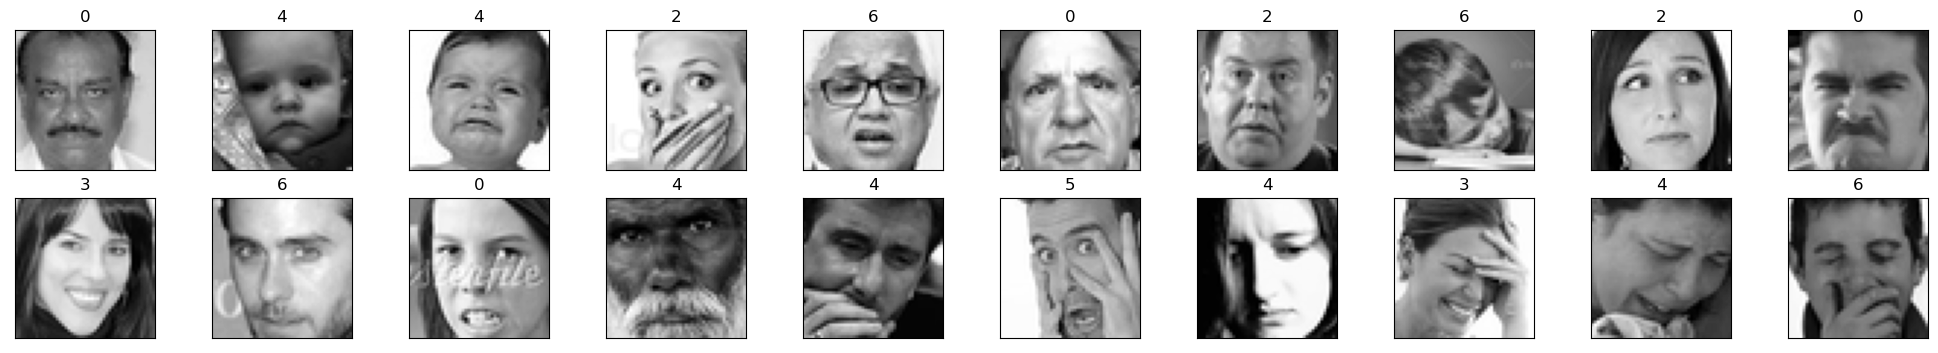

In [55]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(images.shape)
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

# View an Image in More Detail

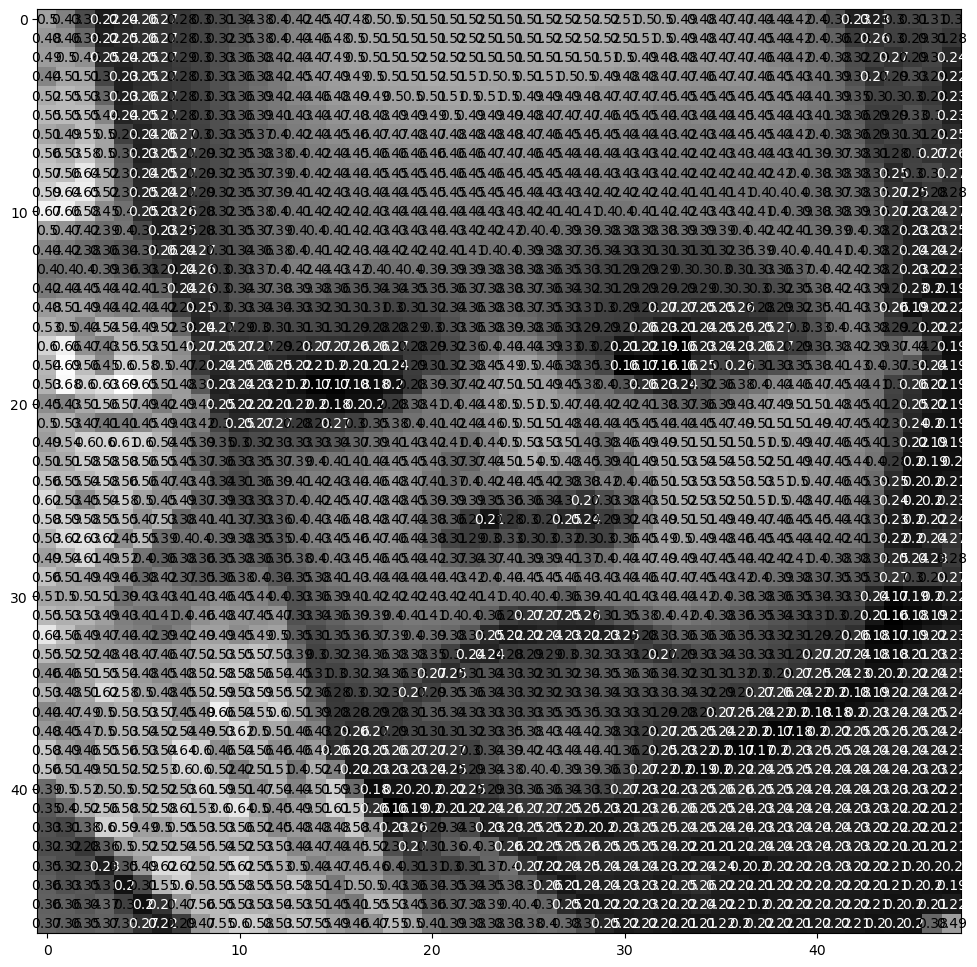

In [56]:
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

In [57]:
np.squeeze(images[1]).shape

(48, 48)

## Define the Network Architecture
We want a very very simple CNN so it is fast and easy to use the explainations for. Let's get inspired by VGG with a mini-VGG

In [156]:
# define the NN architecture
class miniVGG(nn.Module):
    def __init__(self):
        super(miniVGG, self).__init__()
        # 28 x 28
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # 14 x 14
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 96, 3, padding=1)
        # 8 x 8
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Conv2d(96, 128, 3, padding=1)
        self.conv6 = nn.Conv2d(128, 160, 3, padding=1)
        # 4 x 4
        self.pool3 = nn.MaxPool2d(2, 2)
        self.conv7 = nn.Conv2d(160, 192, 3, padding=1)
        self.conv8 = nn.Conv2d(192, 224, 3, padding=1)
        # 1 x 1
        self.pool4 = nn.AvgPool2d(6, 6)
        self.fc1 = nn.Linear(224, 100)
        self.fc2 = nn.Linear(100, 7)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)
        
        self.layers = [self.conv1, self.conv2, self.pool1, 
                       self.conv3, self.conv4, self.pool2, 
                       self.conv5, self.conv6, self.pool3,
                       self.conv7, self.conv8, self.pool4, 
                       self.fc1, self.fc2]
        
        self.return_intermediates = True
        
    def forward(self, x):
        intermediates = []
        def vgg_block(xin, c1, c2, pool):
            xin1 = F.relu(c1(xin))
            xin2 = self.dropout(xin1)
            xin3 = F.relu(c2(xin2))
            xin4 = self.dropout(xin3)
            xin5 = pool(xin4)
            intermediates_ = [xin1, xin2, xin3, xin4, xin5]
            return xin5, intermediates_
        x, i = vgg_block(x, self.conv1, self.conv2, self.pool1)
        intermediates += i
        x, i = vgg_block(x, self.conv3, self.conv4, self.pool2)
        intermediates += i
        x, i = vgg_block(x, self.conv5, self.conv6, self.pool3)
        intermediates += i
        x, i = vgg_block(x, self.conv7, self.conv8, self.pool4)
        intermediates += i
        x = x.view(-1, 224)
        intermediates += [x]
        x = self.dropout(F.relu(self.fc1(x)))
        intermediates += [x]
        x = F.relu(self.fc2(x))
        ### TODO: add the interpediate x's so I can later visualise the filters impact
        if self.return_intermediates:
            return x, intermediates
        else:
            return x

In [174]:
model = miniVGG()
#miniVGG.return_intermediates = False
model

miniVGG(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(128, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv7): Conv2d(160, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(192, 224, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): AvgPool2d(kernel_size=6, stride=6, padding=0)
  (fc1): Linear(in_features=224, out_features=100, bia

In [175]:
prob = nn.LogSoftmax(dim=1)
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [176]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
    model = model.cpu()
    prob = prob.cpu()
    criterion = criterion.cpu()
else:
    print('CUDA is available!  Training on GPU ...')
    model = model.cuda()
    prob = prob.cuda()
    criterion = criterion.cuda()

CUDA is not available.  Training on CPU ...


In [ ]:
# number of epochs to train the model
n_epochs = 5

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output, _ = model(data)
        # print(output)
        # print(torch.sum(output, dim=1))
        # get the log-softmax of the output
        output = prob(output)
        # calculate the batch loss
        loss = criterion(output, target)
        # print(output)
        # print(torch.sum(output, dim=1))
        # print(target)
        # print(loss)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        # break
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    with torch.no_grad():
        for data, target in valid_loader:
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output, _ = model(data)
            # get the log-softmax of the output
            # print(output)
            # print(torch.sum(output, dim=1))
            output = prob(output)
            # calculate the batch loss
            loss = criterion(output, target)
            # print(output)
            # print(torch.sum(output, dim=1))
            # print(target)
            # print(loss)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
            # break
        
        # calculate average losses
        train_loss = train_loss/len(train_loader.sampler)
        valid_loss = valid_loss/len(valid_loader.sampler)
        
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))
    
        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), 'model_mnist.pt')
            valid_loss_min = valid_loss

In [172]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(7))
class_total = list(0. for i in range(7))

model.eval() # prep model for evaluation
model.return_intermediates = False

with torch.no_grad():
    for data, target in valid_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # get the log-softmax of the output
        output = prob(output)
        # calculate the loss
        loss = criterion(output, target)
        # update test loss 
        test_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        # calculate test accuracy for each object class
        for i in range(len(target)):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    # calculate and print avg test loss
    test_loss = test_loss/len(valid_loader.sampler)
    print('Test Loss: {:.6f}\n'.format(test_loss))

    for i in range(7):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                str(i), 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (str(i)))

    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))    

Test Loss: 1.874749

Test Accuracy of     0:  0% ( 0/77)
Test Accuracy of     1:  0% ( 0/ 6)
Test Accuracy of     2:  0% ( 0/85)
Test Accuracy of     3: 100% (147/147)
Test Accuracy of     4:  0% ( 0/103)
Test Accuracy of     5:  0% ( 0/66)
Test Accuracy of     6:  0% ( 0/90)

Test Accuracy (Overall): 25% (147/574)


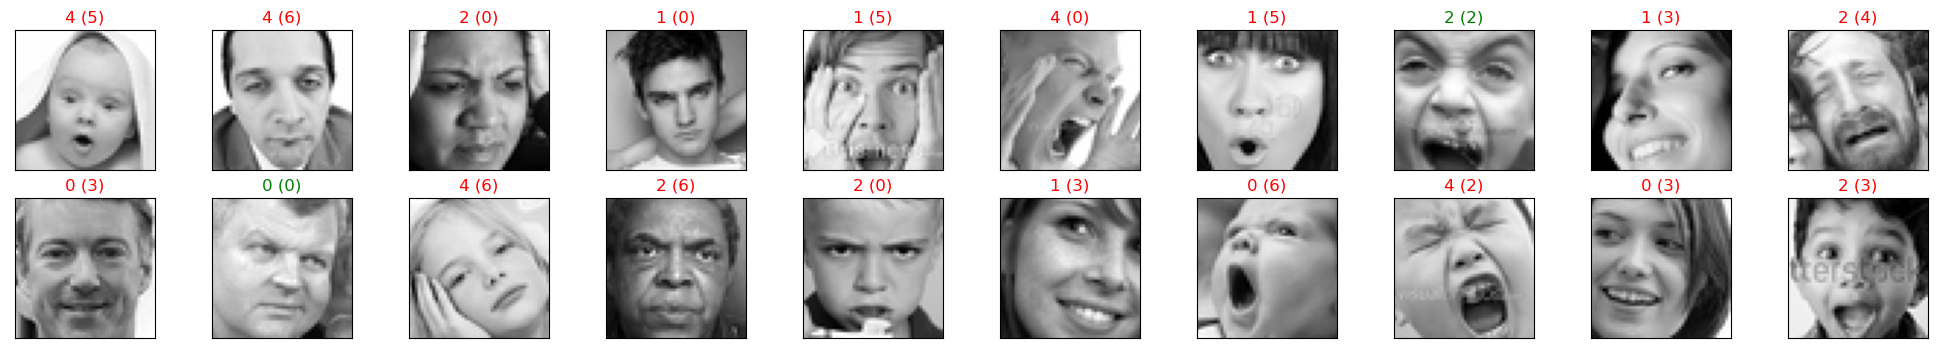

In [142]:
# obtain one batch of test images
dataiter = iter(valid_loader)
images, labels = next(dataiter)
if train_on_gpu:
    images, labels = images.cuda(), labels.cuda()

# get sample outputs
output = model(images)
output = prob(output)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
if train_on_gpu:
    images = images.cpu()
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))